# Baseline do projeto

**Objetivo**: Criar um modelo simples de projeção para todas as nossas séries. 

**Metodologia**: Naive ou HistoricAverage

## 0. Setup

In [1]:
%load_ext autotime

time: 139 µs (started: 2023-12-30 18:14:45 -03:00)


In [57]:
#---- Manipulação de dados:

import pandas as pd
import numpy as np

#---- Modelagem:

from hierarchicalforecast.utils import aggregate
from statsforecast import StatsForecast
from statsforecast.models import HistoricAverage, Naive, SeasonalNaive, AutoARIMA, HoltWinters, AutoETS

#---- Reconciliação

from hierarchicalforecast.methods import BottomUp, TopDown, ERM, OptimalCombination, MinTrace, MiddleOut
from hierarchicalforecast.core import HierarchicalReconciliation

#---- Visualização

import plotly.express as px

time: 105 ms (started: 2023-12-30 18:55:37 -03:00)


## 1. Dados: vendas de roupas no varejo

In [3]:
dados = pd.read_csv('https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-hierarchical-forecasting/main/retail-usa-clothing.csv')

dados.head()

,date,state,item,quantity,region,country
0,1997-11-25,NewYork,mens_clothing,8,Mid-Alantic,USA
1,1997-11-26,NewYork,mens_clothing,9,Mid-Alantic,USA
2,1997-11-27,NewYork,mens_clothing,11,Mid-Alantic,USA
3,1997-11-28,NewYork,mens_clothing,11,Mid-Alantic,USA
4,1997-11-29,NewYork,mens_clothing,10,Mid-Alantic,USA


time: 960 ms (started: 2023-12-30 18:14:47 -03:00)


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388024 entries, 0 to 388023
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      388024 non-null  object
 1   state     388024 non-null  object
 2   item      388024 non-null  object
 3   quantity  388024 non-null  int64 
 4   region    388024 non-null  object
 5   country   388024 non-null  object
dtypes: int64(1), object(5)
memory usage: 17.8+ MB
time: 58.7 ms (started: 2023-12-30 18:14:48 -03:00)


## 2. Modificação nos dados 

Para refletir: isso deveria estar dentro de um pipeline?

Ou não, pois é um estudo pontual, principalmente falando sobre a baseline.

In [5]:
def clean_data_baseline(df: pd.DataFrame):

    #---- 1. Excluindo a variável de country:

    df = df\
        .drop(columns = 'country')

    #---- 2. Mudando o tipo da variável de date para datetime:

    df['date'] = pd.to_datetime(df['date'])

    #---- 3. Renomeando as variáveis de quantidade de vendas e data:
    # date -> ds
    # quantity -> y

    df = df\
        .rename(columns = {'date': 'ds', 
                           'quantity': 'y'})

    return df

time: 770 µs (started: 2023-12-30 18:14:48 -03:00)


In [6]:
df = clean_data_baseline(df = dados)

df.head()

,ds,state,item,y,region
0,1997-11-25,NewYork,mens_clothing,8,Mid-Alantic
1,1997-11-26,NewYork,mens_clothing,9,Mid-Alantic
2,1997-11-27,NewYork,mens_clothing,11,Mid-Alantic
3,1997-11-28,NewYork,mens_clothing,11,Mid-Alantic
4,1997-11-29,NewYork,mens_clothing,10,Mid-Alantic


time: 102 ms (started: 2023-12-30 18:14:48 -03:00)


In [7]:
def format_hierarchical_df(df: pd.DataFrame, cols_hierarchical: list):

    hier_list = [cols_hierarchical[:i] for i in range(1, len(cols_hierarchical) + 1)]

    Y_df, S_df, tags = aggregate(df = df, spec = hier_list)

    return Y_df, S_df, tags

time: 699 µs (started: 2023-12-30 18:14:48 -03:00)


In [8]:
cols_hierarchical = ['region', 'state', 'item']

Y_df, S_df, tags = format_hierarchical_df(df = df, cols_hierarchical = cols_hierarchical)

time: 746 ms (started: 2023-12-30 18:14:48 -03:00)


In [9]:
display(Y_df.head())
display(Y_df.tail())

,ds,y
unique_id,,
EastNorthCentral,1997-11-25,507
EastNorthCentral,1997-11-26,504
EastNorthCentral,1997-11-27,510
EastNorthCentral,1997-11-28,507
EastNorthCentral,1997-11-29,513


,ds,y
unique_id,,
SouthCentral/Tennessee/womens_shoes,2009-07-24,31
SouthCentral/Tennessee/womens_shoes,2009-07-25,30
SouthCentral/Tennessee/womens_shoes,2009-07-26,31
SouthCentral/Tennessee/womens_shoes,2009-07-27,29
SouthCentral/Tennessee/womens_shoes,2009-07-28,30


time: 15.3 ms (started: 2023-12-30 18:14:49 -03:00)


- **Dados de treino: 25/11/1997 a 31/12/2008**
- **Dados de validação: 01/01/2009 a 28/07/2009**

In [10]:
def split_train_test(df: pd.DataFrame, dt_start_train: str):

    train = df.query(f'ds < "{dt_start_train}"')

    valid = df.query(f'ds >= "{dt_start_train}"')

    return train, valid

time: 710 µs (started: 2023-12-30 18:14:49 -03:00)


In [11]:
Y_train_df, Y_valid_df = split_train_test(df = Y_df, dt_start_train = '2009-01-01')

time: 84 ms (started: 2023-12-30 18:14:49 -03:00)


In [12]:
display(Y_train_df.head())
display(Y_train_df.tail())

,ds,y
unique_id,,
EastNorthCentral,1997-11-25,507
EastNorthCentral,1997-11-26,504
EastNorthCentral,1997-11-27,510
EastNorthCentral,1997-11-28,507
EastNorthCentral,1997-11-29,513


,ds,y
unique_id,,
SouthCentral/Tennessee/womens_shoes,2008-12-27,31
SouthCentral/Tennessee/womens_shoes,2008-12-28,29
SouthCentral/Tennessee/womens_shoes,2008-12-29,28
SouthCentral/Tennessee/womens_shoes,2008-12-30,31
SouthCentral/Tennessee/womens_shoes,2008-12-31,31


time: 12.6 ms (started: 2023-12-30 18:14:49 -03:00)


## 3. Modelagem

### 3.1. Fit do modelo

In [13]:
# his_avg = HistoricAverage()
naive = Naive()
# seas_naive = SeasonalNaive(season_length = 7)
arima = AutoARIMA(season_length = 7)
hw = HoltWinters(season_length = 7, error_type = 'A')
ets = AutoETS(season_length = 7)

model = StatsForecast(models = [naive, arima, hw, ets], freq = 'D', n_jobs = -1)
model.fit(Y_train_df)

StatsForecast(models=[Naive,AutoARIMA,HoltWinters,AutoETS])

time: 6min 5s (started: 2023-12-30 18:14:49 -03:00)


### 3.2. Predict para comparação entre os dados de validação

In [14]:
n_horizon = Y_valid_df.ds.nunique()

Y_hat_df = model.forecast(h = n_horizon, fitted = True)

Y_hat_df.head()

Forecast: 100%|█████████████████████████████████| 15/15 [05:35<00:00, 22.37s/it]


,ds,Naive,AutoARIMA,HoltWinters,AutoETS
unique_id,,,,,
EastNorthCentral,2009-01-01,924.0,922.722961,922.791016,922.932312
EastNorthCentral,2009-01-02,924.0,923.092468,922.377808,922.932861
EastNorthCentral,2009-01-03,924.0,923.023865,922.800781,922.933350
EastNorthCentral,2009-01-04,924.0,923.023865,922.498047,922.933838
EastNorthCentral,2009-01-05,924.0,922.937805,923.066284,922.934326


time: 5min 35s (started: 2023-12-30 18:20:54 -03:00)


In [15]:
Y_fitted_df = model.forecast_fitted_values()

display(Y_fitted_df.head())
display(Y_fitted_df.tail())

,ds,y,Naive,AutoARIMA,HoltWinters,AutoETS
unique_id,,,,,,
EastNorthCentral,1997-11-25,507.0,NaN,506.493011,503.918365,505.399323
EastNorthCentral,1997-11-26,504.0,507.0,506.756775,510.603271,508.149139
EastNorthCentral,1997-11-27,510.0,504.0,505.160217,510.609741,507.679291
EastNorthCentral,1997-11-28,507.0,510.0,507.876160,512.988464,510.753601
EastNorthCentral,1997-11-29,513.0,507.0,507.672363,512.523865,510.430145


,ds,y,Naive,AutoARIMA,HoltWinters,AutoETS
unique_id,,,,,,
SouthCentral/Tennessee/womens_shoes,2008-12-27,31.0,31.0,30.347441,30.314579,30.346684
SouthCentral/Tennessee/womens_shoes,2008-12-28,29.0,31.0,30.502066,30.483852,30.501236
SouthCentral/Tennessee/womens_shoes,2008-12-29,28.0,29.0,30.146147,30.212399,30.146093
SouthCentral/Tennessee/womens_shoes,2008-12-30,31.0,28.0,29.637609,29.761269,29.638397
SouthCentral/Tennessee/womens_shoes,2008-12-31,31.0,31.0,29.960432,29.948727,29.960508


time: 46 ms (started: 2023-12-30 18:26:30 -03:00)


In [16]:
#---- TO-DO: provar que as somas das projeções dos modelos não batem no Y_hat_df

Y_hat_df\
    .reset_index()\
    .assign(\
        nivel_hierarquia = lambda x: np.where(x['unique_id'].str.count('/') == 0, 1, x['unique_id'].str.count('/') + 1)
    )\
    .groupby('nivel_hierarquia')[['Naive', 'AutoARIMA', 'HoltWinters', 'AutoETS']]\
    .sum()

,Naive,AutoARIMA,HoltWinters,AutoETS
nivel_hierarquia,,,,
1,1338645.0,1338000.25,1357769.875,1336006.125
2,1338645.0,1338252.75,1350473.875,1337531.625
3,1338645.0,1338156.75,1347612.125,1344819.375


time: 42.7 ms (started: 2023-12-30 18:26:30 -03:00)


## 4. Reconciliação

In [17]:
reconcilers = [BottomUp(), 
               TopDown(method = 'forecast_proportions'),
               TopDown(method = 'average_proportions'),
               TopDown(method = 'proportion_averages'),
               MiddleOut(middle_level = 'region/state', top_down_method = 'forecast_proportions'),
               MiddleOut(middle_level = 'region/state', top_down_method = 'average_proportions'),
               MiddleOut(middle_level = 'region/state', top_down_method = 'proportion_averages'),
               MinTrace(method = 'ols', nonnegative = True),
               MinTrace(method = 'wls_struct', nonnegative = True),
               MinTrace(method = 'wls_var', nonnegative = True),
               MinTrace(method = 'mint_shrink', nonnegative = True),
               # MinTrace(method = 'mint_cov', nonnegative = True), # Não descomentar essa linha
               OptimalCombination(method = 'ols', nonnegative = True),
               OptimalCombination(method = 'wls_struct', nonnegative = True)
              ]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)

time: 47.3 ms (started: 2023-12-30 18:26:30 -03:00)


In [18]:
Y_rec_df = hrec.reconcile(Y_hat_df = Y_hat_df, 
                          Y_df = Y_fitted_df,
                          S = S_df,
                          tags = tags)

time: 9.32 s (started: 2023-12-30 18:26:30 -03:00)


In [19]:
Y_rec_df

,ds,Naive,AutoARIMA,HoltWinters,AutoETS,Naive/BottomUp,AutoARIMA/BottomUp,HoltWinters/BottomUp,AutoETS/BottomUp,Naive/TopDown_method-forecast_proportions,...,HoltWinters/MinTrace_method-mint_shrink_nonnegative-True,AutoETS/MinTrace_method-mint_shrink_nonnegative-True,Naive/OptimalCombination_method-ols_nonnegative-True,AutoARIMA/OptimalCombination_method-ols_nonnegative-True,HoltWinters/OptimalCombination_method-ols_nonnegative-True,AutoETS/OptimalCombination_method-ols_nonnegative-True,Naive/OptimalCombination_method-wls_struct_nonnegative-True,AutoARIMA/OptimalCombination_method-wls_struct_nonnegative-True,HoltWinters/OptimalCombination_method-wls_struct_nonnegative-True,AutoETS/OptimalCombination_method-wls_struct_nonnegative-True
unique_id,,,,,,,,,,,,,,,,,,,,,
EastNorthCentral,2009-01-01,924.0,922.722961,922.791016,922.932312,924.0,922.579468,922.737305,922.729126,0.0,...,922.956665,922.961914,924.0,922.802734,922.902771,923.034302,924.0,922.796326,922.933044,923.020874
EastNorthCentral,2009-01-02,924.0,923.092468,922.377808,922.932861,924.0,922.413635,922.699097,922.865356,0.0,...,922.797363,922.982666,924.0,923.114990,922.532593,923.041199,924.0,922.942993,922.680176,923.066467
EastNorthCentral,2009-01-03,924.0,923.023865,922.800781,922.933350,924.0,922.112183,923.269165,923.001587,0.0,...,923.255493,923.044983,924.0,922.992676,922.926025,923.047974,924.0,922.737000,923.101074,923.112061
EastNorthCentral,2009-01-04,924.0,923.023865,922.498047,922.933838,924.0,922.128540,923.110962,923.137817,0.0,...,923.095703,923.124023,924.0,923.029663,922.716797,923.054810,924.0,922.793152,922.967651,923.157715
EastNorthCentral,2009-01-05,924.0,922.937805,923.066284,922.934326,924.0,921.988831,923.490601,923.274048,0.0,...,923.488403,923.183472,924.0,922.903320,923.222412,923.061646,924.0,922.636475,923.398071,923.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SouthCentral/Tennessee/womens_shoes,2009-07-24,31.0,30.206762,30.586092,30.206419,31.0,30.206762,30.586092,30.206419,31.0,...,30.446545,29.938560,31.0,30.133802,29.778969,29.023344,31.0,30.163857,29.939159,29.554914
SouthCentral/Tennessee/womens_shoes,2009-07-25,31.0,30.206762,30.577198,30.206419,31.0,30.206762,30.577198,30.206419,31.0,...,30.428486,29.937931,31.0,30.133802,29.698889,29.021778,31.0,30.163857,29.896362,29.554249
SouthCentral/Tennessee/womens_shoes,2009-07-26,31.0,30.206762,30.583687,30.206419,31.0,30.206762,30.583687,30.206419,31.0,...,30.444683,29.937727,31.0,30.133802,29.742184,29.021584,31.0,30.163857,29.921080,29.555283


time: 26.7 ms (started: 2023-12-30 18:26:40 -03:00)


## 5. Avaliação das métricas: WMAPE e RMSE

In [24]:
def wmape(y_true, y_pred):
    
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def rmse(y_true, y_pred):
    
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

time: 1.05 ms (started: 2023-12-30 18:39:24 -03:00)


In [29]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

evaluator = HierarchicalEvaluation(evaluators = [rmse, wmape])

evaluation = evaluator.evaluate(
    Y_hat_df = Y_rec_df,
    Y_test_df = Y_valid_df,
    tags = tags
)

time: 137 ms (started: 2023-12-30 18:40:21 -03:00)


In [62]:
df_metricas_modelos = pd.melt(evaluation.reset_index(), id_vars = ['level', 'metric'])\
    .sort_values(by = 'value', ascending = True)\
    .groupby(['level', 'metric'])\
    .head(2)\
    .query('level != "Overall"')

df_metricas_baseline = pd.melt(evaluation.reset_index(), id_vars = ['level', 'metric'])\
    .query('variable == "Naive" & level != "Overall"')

df_metricas = pd.concat([df_metricas_modelos, df_metricas_baseline])\
    .sort_values(by = 'level')\
    .query('level != "Overall"')\
    .reset_index(drop = True)

df_metricas

,level,metric,variable,value
0,region,wmape,HoltWinters/MinTrace_method-wls_struct_nonnega...,0.011354
1,region,wmape,HoltWinters/OptimalCombination_method-wls_stru...,0.011354
2,region,wmape,Naive,0.013803
3,region,rmse,Naive,22.448943
4,region,rmse,HoltWinters/MinTrace_method-wls_struct_nonnega...,18.517012
5,region,rmse,HoltWinters/OptimalCombination_method-wls_stru...,18.517012
6,region/state,wmape,Naive,0.021031
7,region/state,rmse,Naive,11.248096
8,region/state,rmse,HoltWinters/MinTrace_method-mint_shrink_nonneg...,10.542839
9,region/state,rmse,HoltWinters/BottomUp,10.247573


time: 37.1 ms (started: 2023-12-30 18:59:17 -03:00)


## TO-DO: ajustar o gráfico

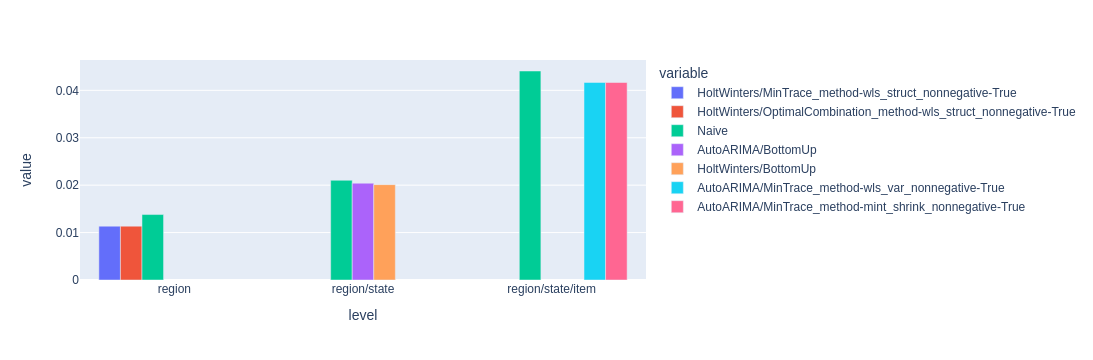

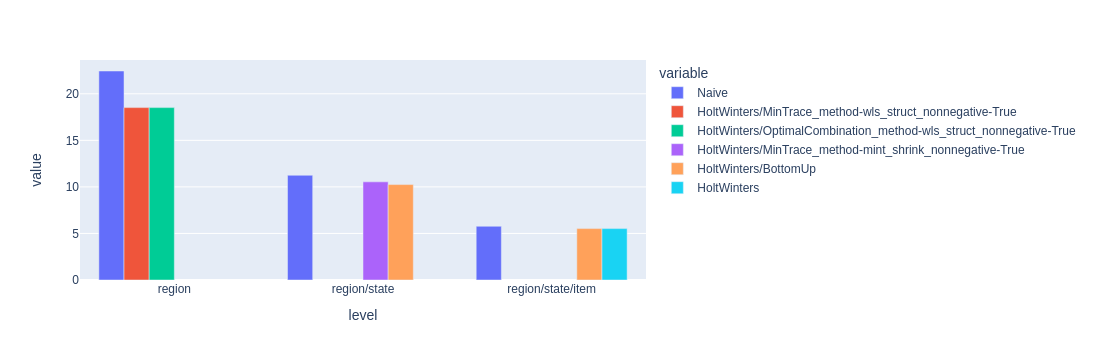

time: 139 ms (started: 2023-12-30 18:59:26 -03:00)


In [63]:
for metric in df_metricas.metric.unique():

    df_temp = df_metricas\
        .query(f'metric == "{metric}"')

    fig = px.bar(data_frame = df_temp, x = 'level', y = 'value', color = 'variable', barmode = 'group')
    fig.show()